Standart floquette stability analysis 

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Systemparameter
kappa = 1
gamma = 1
Gamma = 2
delta_1 = 1
delta_2 = 1
Omega =4
V = -4
eta = 1
g_0 = 1

# Anfangswerte basierend auf den gegebenen Bedingungen
a0 = 2 * eta / kappa + 0j
a_dagger_0 = 2 * eta / kappa + 0j
psi00 = (delta_2 / (2 * V) + 1)
psi22 = -delta_2 / (2 * V)

V_cond = -delta_2 / 2 * ((Omega * kappa)**2 / (16 * (eta * gamma)**2) + 1)

if V < V_cond:    
    psi20 = (Omega * kappa * delta_2 / (8 * eta * gamma * V))
    psi02 = np.conj(psi20)
else:
    psi02 = -(4 * eta * gamma / (Omega * kappa) * (delta_2 / (2 * V) + 1))
    psi20 = np.conj(psi02)

psi11 = 0 + 0j
psi10 = 0.0 + 0j
psi01 = 0.0 + 0j
psi21 = 0.0 + 0j
psi12 = 0.0 + 0j

startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

# Differentialgleichungssystem
def dydt(t, y):
    a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
    
    da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
    da_dagger_dt = np.conj(da_dt)
    dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
    dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega/2 * ket02)
    dket10_dt = np.conj(dket01_dt)
    dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega/2 * (ket21 - ket12)
    dket22_dt = 1j * Omega / 2 * (ket12 - ket21)
    dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega/2 * (ket11 - ket22) + 2 * V * ket21 * ket22)
    dket12_dt = np.conj(dket21_dt)
    dket02_dt = 1j * (-delta_2 * ket02 - Omega/2 * ket01 - 2 * V * ket02 * ket22 + gamma * ket12 * a)
    dket20_dt = np.conj(dket02_dt)
    
    return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

# Numerische Berechnung der Jacobi-Matrix mit finite Differenzen
def numerical_jacobian(y, dydt, epsilon=1e-8):
    n = len(y)
    J_num = np.zeros((n, n), dtype=complex)
    
    # Zentrale Differenzenmethode
    for i in range(n):
        y_eps_plus = np.copy(y)
        y_eps_minus = np.copy(y)
        y_eps_plus[i] += epsilon
        y_eps_minus[i] -= epsilon
        
        f_eps_plus = np.array(dydt(0, y_eps_plus))
        f_eps_minus = np.array(dydt(0, y_eps_minus))
        
        J_num[:, i] = (f_eps_plus - f_eps_minus) / (2 * epsilon)
    
    return J_num

# Numerische Integration mit DOP853
t_span = (0, 5000)  # Längere Simulationszeit
t_eval = np.linspace(0, 5000, 500000)  # Höhere Auflösung
sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, atol=1e-12, rtol=1e-12)

# Definition von t und y
t = sol.t
y = sol.y

# Maxima finden (nach den ersten 500 Sekunden)
def find_maxima(y, t, ignore_time=500):
    maxima_indices = []
    ignore_index = np.searchsorted(t, ignore_time)
    for i in range(ignore_index, len(y) - 1):
        if y[i - 1] < y[i] and y[i + 1] < y[i]:
            maxima_indices.append(i)
    return maxima_indices

# Maxima für jede Lösung finden
maxima_indices_list = []
periods = []

for i in range(len(y)):
    maxima_indices = find_maxima(np.real(y[i]), t)
    maxima_indices_list.append(maxima_indices)
    if len(maxima_indices) > 1:
        period = np.mean(np.diff(t[maxima_indices]))
        periods.append(period)
    else:
        periods.append(np.nan)

# # Abstände der ersten und letzten 5 Maxima vergleichen
# for i in range(len(y)):
#     if len(maxima_indices_list[i]) >= 10:
#         first_five_maxima = y[i, maxima_indices_list[i][:5]]
#         last_five_maxima = y[i, maxima_indices_list[i][-5:]]
#         print(f"Lösung {i}:")
#         print(f"  Erste 5 Maxima: {first_five_maxima}")
#         print(f"  Letzte 5 Maxima: {last_five_maxima}")

#         # Abstände der Maxima berechnen
#         first_distances = np.diff(t[maxima_indices_list[i][:5]])
#         last_distances = np.diff(t[maxima_indices_list[i][-5:]])
#         print(f"  Abstände der ersten 5 Maxima: {first_distances}")
#         print(f"  Abstände der letzten 5 Maxima: {last_distances}")

# Floquet-Analyse über mehrere Perioden mit linearisiertem System
def floquet_analysis(sol, periods, num_periods=5):
    t_fin = sol.t[-1]
    t_start = t_fin - periods[-1] * num_periods
    y0 = sol.sol(t_start)
    n = len(y0)
    J0 = np.eye(n, dtype=complex)  # Initial matrix is identity

    def variational_eq(t, Y):
        Y = Y.reshape((n, n + 1))
        dy = dydt(t, Y[:, 0])
        A = numerical_jacobian(Y[:, 0], dydt)
        
        dYdt = np.zeros_like(Y)
        dYdt[:, 0] = dy
        dYdt[:, 1:] = A @ Y[:, 1:]
        return dYdt.flatten()

    t_eval = np.linspace(t_start, t_fin, num_periods * 100)
    Y0 = np.hstack([y0[:, None], J0]).flatten()
    sol_var = solve_ivp(variational_eq, [t_start, t_fin], Y0, t_eval=t_eval, method='DOP853', dense_output=True)

    YT = sol_var.sol(t_fin).reshape((n, n + 1))
    monodromy_matrix = YT[:, 1:]
    floquet_multipliers = np.linalg.eigvals(monodromy_matrix)

    # Skalieren der Floquet-Multiplikatoren für eine Periode
    floquet_multipliers_single_period = np.power(floquet_multipliers, 1/num_periods)

    return floquet_multipliers_single_period

# Berechnung der Floquet-Multiplikatoren für jede Periode
floquet_results = []
for i, period in enumerate(periods):
    if not np.isnan(period):
        print(f"Lösung {i}: Periode = {period}")
        floquet_multipliers = floquet_analysis(sol, periods, num_periods=5)
        floquet_results.append((i, floquet_multipliers))
        print(f"Floquet-Multiplikatoren für Lösung {i}:")
        for j in floquet_multipliers:
            print(abs(j))

# Floquet-Ergebnisse anzeigen
import math 
for result in floquet_results:
    i, multipliers = result
    print(f"Lösung {i}:")
    for multiplier in multipliers:
        print(np.real(multiplier ))
    # for multiplier in multipliers:
    #     if math.isclose(multiplier, 1.0, rel_tol=10**(-8)):
    #         print(f" stable:{abs(multiplier)}")
    #     elif abs(multiplier)<1-10**(-8):
    #         print(f" decaying:{abs(multiplier)}")
    #     elif abs(multiplier)>1+10**(-8):
    #         print(f" increasing:{abs(multiplier)}")


Lösung 0: Periode = 1.858759915866939
Floquet-Multiplikatoren für Lösung 0:
4.017237407957172
0.9788767357222161
0.7662782071937695
1.000000001380657
0.6353430770878463
0.4926537874320893
0.42279058720553586
0.2140753982583224
0.18536837985489743
0.13009880264401863
0.11317545944973716
Lösung 1: Periode = 1.858759915866939
Floquet-Multiplikatoren für Lösung 1:
4.017237407957172
0.9788767357222161
0.7662782071937695
1.000000001380657
0.6353430770878463
0.4926537874320893
0.42279058720553586
0.2140753982583224
0.18536837985489743
0.13009880264401863
0.11317545944973716
Lösung 2: Periode = 1.8587557836272695
Floquet-Multiplikatoren für Lösung 2:
4.017237407957172
0.9788767357222161
0.7662782071937695
1.000000001380657
0.6353430770878463
0.4926537874320893
0.42279058720553586
0.2140753982583224
0.18536837985489743
0.13009880264401863
0.11317545944973716
Lösung 3: Periode = 1.8587557836272695
Floquet-Multiplikatoren für Lösung 3:
4.017237407957172
0.9788767357222161
0.7662782071937695
1.000

daten einlesen

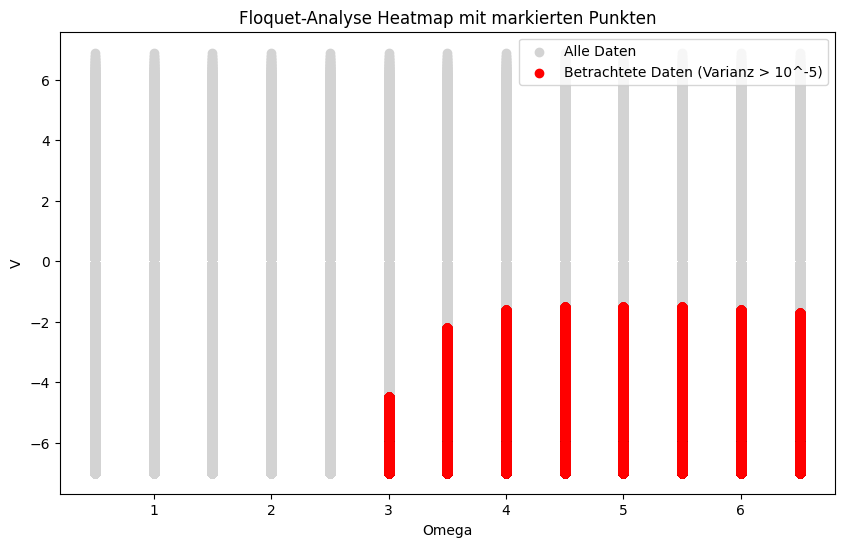

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Daten laden
df_full = pd.read_pickle(r"/home/paul/Documents/atm/Bachelor-Arbeit-master/ground_state_final_test_12_08.pkl")

# Extrahiere relevante Parameter und Varianzen
Omega = np.array([params[3] for params in df_full['additional params']])
V_vals = np.array([params[7] for params in df_full['additional params']])

psi_00_var = df_full['var_<0|0>'].to_numpy()
psi_11_var = df_full['var_<1|1>'].to_numpy()
psi_22_var = df_full['var_<2|2>'].to_numpy()

# Filter für Varianzen größer als 10^-5
variance_threshold = 1e-5
filtered_indices = np.where((psi_00_var > variance_threshold) | 
                            (psi_11_var > variance_threshold) | 
                            (psi_22_var > variance_threshold))[0]

# Erstellen der Heatmap
plt.figure(figsize=(10, 6))

# Streuplot der gesamten Daten (graue Punkte als Hintergrund)
plt.scatter(Omega, V_vals, color='lightgray', label='Alle Daten')

# Hervorheben der gefilterten Daten (rote Punkte)
plt.scatter(Omega[filtered_indices], V_vals[filtered_indices], color='red', label='Betrachtete Daten (Varianz > 10^-5)')

plt.xlabel('Omega')
plt.ylabel('V')
plt.title('Floquet-Analyse Heatmap mit markierten Punkten')
plt.legend()
plt.show()

Floquette analyse durchführen

In [2]:
filtered_indices 

array([   211,    212,    213, ..., 126358, 126359, 126360])

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from scipy.integrate import solve_ivp
# Nur gefilterte Werte verwenden
filtered_Omega = Omega[filtered_indices]
filtered_V_vals = V_vals[filtered_indices]

# Unique Omega-Werte finden (in den gefilterten Daten)
unique_Omega = np.unique(filtered_Omega)

# Dictionary für die Anzahl instabiler Floquet-Multiplikatoren
floquet_results = {omega: [] for omega in unique_Omega}

def floquet_analysis(omega, v, idx):
    # Setze Systemparameter
    params = df_full.iloc[idx]['additional params']
    kappa, gamma, Gamma, Omega, delta_1, delta_2, eta, V = params

    # Anfangsbedingungen
    a0 = 0
    a_dagger_0 = 0
    psi00 = 1
    psi22 = 0
    psi02 = 0
    psi20 = 0
    psi11 = 0 + 0j
    psi10 = 0.0 + 0j
    psi01 = 0.0 + 0j
    psi21 = 0.0 + 0j
    psi12 = 0.0 + 0j

    startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

    # Differentialgleichungssystem
    def dydt(t, y):
        a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
        
        da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
        da_dagger_dt = np.conj(da_dt)
        dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
        dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega/2 * ket02)
        dket10_dt = np.conj(dket01_dt)
        dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega/2 * (ket21 - ket12)
        dket22_dt = 1j * Omega / 2 * (ket12 - ket21)
        dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega/2 * (ket11 - ket22) + 2 * V * ket21 * ket22)
        dket12_dt = np.conj(dket21_dt)
        dket02_dt = 1j * (-delta_2 * ket02 - Omega/2 * ket01 - 2 * V * ket02 * ket22 + gamma * ket12 * a)
        dket20_dt = np.conj(dket02_dt)
        
        return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

    # Numerische Integration
    t_span = (0, 2000)
    t_eval = np.linspace(0, 2000, 20000)
    sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, atol=1e-8, rtol=1e-10)

    # Floquet-Analyse
    def numerical_jacobian(y, dydt, epsilon=1e-8):
        n = len(y)
        J_num = np.zeros((n, n), dtype=complex)
        for i in range(n):
            y_eps_plus = np.copy(y)
            y_eps_minus = np.copy(y)
            y_eps_plus[i] += epsilon
            y_eps_minus[i] -= epsilon
            f_eps_plus = np.array(dydt(0, y_eps_plus))
            f_eps_minus = np.array(dydt(0, y_eps_minus))
            J_num[:, i] = (f_eps_plus - f_eps_minus) / (2 * epsilon)
        return J_num

    def floquet_analysis_inner(sol, periods, num_periods=5):
        t_fin = sol.t[-1]
        t_start = t_fin - periods[-1] * num_periods
        y0 = sol.sol(t_start)
        n = len(y0)
        J0 = np.eye(n, dtype=complex)

        def variational_eq(t, Y):
            Y = Y.reshape((n, n + 1))
            dy = dydt(t, Y[:, 0])
            A = numerical_jacobian(Y[:, 0], dydt)
            
            dYdt = np.zeros_like(Y)
            dYdt[:, 0] = dy
            dYdt[:, 1:] = A @ Y[:, 1:]
            return dYdt.flatten()

        t_eval = np.linspace(t_start, t_fin, num_periods * 100)
        Y0 = np.hstack([y0[:, None], J0]).flatten()
        sol_var = solve_ivp(variational_eq, [t_start, t_fin], Y0, t_eval=t_eval, method='DOP853', dense_output=True)

        YT = sol_var.sol(t_fin).reshape((n, n + 1))
        monodromy_matrix = YT[:, 1:]
        floquet_multipliers = np.linalg.eigvals(monodromy_matrix)
        floquet_multipliers_single_period = np.power(floquet_multipliers, 1/num_periods)

        return floquet_multipliers_single_period

    # Maxima für jede Lösung finden
    def find_maxima(y, t, ignore_time=500):
        maxima_indices = []
        ignore_index = np.searchsorted(t, ignore_time)
        for i in range(ignore_index, len(y) - 1):
            if y[i - 1] < y[i] and y[i + 1] < y[i]:
                maxima_indices.append(i)
        return maxima_indices

    y = sol.y
    periods = []
    for i in range(len(y)):
        maxima_indices = find_maxima(np.real(y[i]), sol.t)
        if len(maxima_indices) > 1:
            period = np.mean(np.diff(sol.t[maxima_indices]))
            periods.append(period)
        else:
            periods.append(np.nan)

    if not np.isnan(periods).all():
        floquet_multipliers = floquet_analysis_inner(sol, periods, num_periods=5)
        num_unstable = np.sum(np.abs(floquet_multipliers) > 1.0)
        return num_unstable
    else:
        return -1

# Funktion zur Multithreading-Ausführung
def analyze_omega(omega):
    indices_for_omega = np.where(filtered_Omega == omega)[0]
    results = []
    for idx in indices_for_omega:
        results.append(floquet_analysis(omega, filtered_V_vals[idx], idx))
    return omega, results

# Multithreading zur parallelen Ausführung
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(analyze_omega, omega): omega for omega in unique_Omega}
    for future in futures:
        omega, results = future.result()
        floquet_results[omega] = results

# Erstellen der Heatmap
heatmap_data = []

for omega in unique_Omega:
    for i, v in enumerate(filtered_V_vals[np.where(filtered_Omega == omega)[0]]):
        num_unstable = floquet_results[omega][i]
        heatmap_data.append((omega, v, num_unstable))

# Konvertiere die Heatmap-Daten in ein numpy-Array
heatmap_data = np.array(heatmap_data)

# Erstellen des Plots
plt.figure(figsize=(10, 6))

# Plot für die analysierten Punkte
scatter = plt.scatter(heatmap_data[:, 0], heatmap_data[:, 1], c=heatmap_data[:, 2],
                      cmap='viridis', vmin=-1, vmax=4, s=100)

# Hintergrunddaten (alle Daten, aber grau dargestellt)
plt.scatter(Omega, V_vals, color='lightgray', label='Alle Daten')

plt.xlabel('Omega')
plt.ylabel('V')
plt.title('Floquet-Analyse mit markierten Ergebnissen')
plt.colorbar(scatter, label='Anzahl der instabilen Floquet-Multiplikatoren')
plt.show()